In [1]:
from __future__ import print_function, division
# from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import torchvision.models as models
# import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
import numpy as np
import random
import torch
import copy
import time
import os

from image_loader import SchoolDataset, SchoolDatasetBinary
from attnNet import *
from helpers import *

In [2]:
dataset = SchoolDatasetBinary("./data/y1314_AllSubjects.csv", "./data/imagery/")

x_train, y_train, x_val, y_val = train_test_split(dataset, .80)

train = [(k,v) for k,v in zip(x_train, y_train)]
val = [(k,v) for k,v in zip(x_val, y_val)]


print(len(train))
print(len(val))

dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)

batchSize = 32

# Prep the training and validation set
train = torch.utils.data.DataLoader(train, batch_size = batchSize, shuffle = True)
val = torch.utils.data.DataLoader(val, batch_size = batchSize, shuffle = True)


dataloaders = {}
dataloaders['train'] = train
dataloaders['val'] = val

4700
1175


In [3]:
dataset[0]

(tensor([[[0.1373, 0.0471, 0.1255,  ..., 0.2549, 0.1608, 0.0078],
          [0.1922, 0.1373, 0.1686,  ..., 0.2588, 0.0784, 0.0078],
          [0.2588, 0.2235, 0.2275,  ..., 0.2235, 0.0000, 0.0078],
          ...,
          [0.0706, 0.0706, 0.0706,  ..., 0.0471, 0.0157, 0.0157],
          [0.0510, 0.0706, 0.0824,  ..., 0.0157, 0.0118, 0.0118],
          [0.0510, 0.0784, 0.1059,  ..., 0.0118, 0.0118, 0.0157]],
 
         [[0.2627, 0.1647, 0.2510,  ..., 0.3804, 0.2627, 0.1294],
          [0.2980, 0.2627, 0.2941,  ..., 0.3608, 0.1882, 0.1294],
          [0.3608, 0.3294, 0.3608,  ..., 0.3294, 0.0980, 0.1294],
          ...,
          [0.1059, 0.1059, 0.1059,  ..., 0.0863, 0.0510, 0.0510],
          [0.0980, 0.1059, 0.1294,  ..., 0.0510, 0.0353, 0.0353],
          [0.0980, 0.1176, 0.1333,  ..., 0.0353, 0.0353, 0.0510]],
 
         [[0.3137, 0.2196, 0.2980,  ..., 0.4157, 0.3176, 0.1647],
          [0.3451, 0.3137, 0.3451,  ..., 0.4078, 0.2353, 0.1647],
          [0.4078, 0.3765, 0.4078,  ...,

In [12]:
import numpy as np
import random
import torch



class channelMaxPool(torch.nn.Module):
    def __init__(self, in_channels, h, w, batch_size):
        super(channelMaxPool, self).__init__()
        self.batch_size = batch_size
        self.h = h
        self.w = h


    def forward(self, x):
        # torch.reshape(v, (1,2,2))
        x, i = torch.max(x, dim = 1)
        return torch.reshape(x, (x.shape[0], 1, self.h, self.w))


class spatialMaxPool(torch.nn.Module):
    def __init__(self, in_channels, batch_size):
        super(spatialMaxPool, self).__init__()
        self.in_channels = in_channels
        self.batch_size = batch_size

    def forward(self, x):
        x, i = torch.max(x, dim = -1)
        x, i = torch.max(x, dim = -1)
        return torch.reshape(x, (x.shape[0], self.in_channels, 1, 1))


class channelAvgPool(torch.nn.Module):
    def __init__(self, in_channels, h, w, batch_size):
        super(channelAvgPool, self).__init__()
        self.batch_size = batch_size
        self.h = h
        self.w = h


    def forward(self, x):
        x = torch.mean(x, dim = 1)
        return torch.reshape(x, (x.shape[0], 1, self.h, self.w))


class spatialAvgPool(torch.nn.Module):
    def __init__(self, in_channels, batch_size):
        super(spatialAvgPool, self).__init__()
        self.in_channels = in_channels
        self.batch_size = batch_size

    def forward(self, x):
        x = torch.mean(x, dim = -1)
        x = torch.mean(x, dim = -1)
        return torch.reshape(x, (x.shape[0], self.in_channels, 1, 1))



class attnNetBinary(torch.nn.Module):
    def __init__(self, in_channels, h, w, batch_size, resnet):
        super(attnNetBinary, self).__init__()

        # Normal resnet stuff
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.linear = torch.nn.Linear(in_features=2048, out_features = 2, bias = True)


        # Attention layers
        self.sMP = spatialMaxPool(in_channels = 2048, batch_size = batch_size)
        self.cMP = channelMaxPool(in_channels = 2048, h = 7, w = 7, batch_size = batch_size)
        self.sAP = spatialAvgPool(in_channels = 2048, batch_size = batch_size)
        self.cAP = channelAvgPool(in_channels = 2048, h = 7, w = 7, batch_size = batch_size)
        # self.out_channels = int(in_channels/16)
        self.out_channels = in_channels
        self.convR_M = torch.nn.Conv2d(in_channels = 2048, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convA_M = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convB_M = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (3,3), bias=True, padding = 1)
        self.convC_M = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (7,7), bias=True, padding = 3)
        self.convE_M = torch.nn.Conv2d(in_channels = self.out_channels * 3, out_channels = 2048, kernel_size = (1,1), bias=True)
        
        self.convR_A = torch.nn.Conv2d(in_channels = 2048, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convA_A = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convB_A = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (3,3), bias=True, padding = 1)
        self.convC_A = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (7,7), bias=True, padding = 3)
        self.convE_A = torch.nn.Conv2d(in_channels = self.out_channels * 3, out_channels = 2048, kernel_size = (1,1), bias=True)

        self.bn2 = torch.nn.BatchNorm2d(2048)

        self.sigmoid = torch.nn.Sigmoid()

        self.sm = torch.nn.Softmax()

    def forward(self, x):

        # print(x.shape)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.avgpool(out)
        # out = out.flatten(start_dim=1)
        # out = self.linear(out)

        # print(out.shape)

        out = self.bn2(out)


        # Max Pooling
        fsM = self.sMP(out)
        fcM = self.cMP(out)
        fscM = torch.mul(fsM, fcM)
        rM = self.convR_M(fscM)
        aM = self.convA_M(rM)
        bM = self.convB_M(rM)
        cM = self.convC_M(rM)
        catM = torch.cat((aM,bM,cM), dim = 1)
        eM = self.convE_M(catM)


        # Avg Pooling
        fsA = self.sAP(out)
        fcA = self.cAP(out)
        fscA = torch.mul(fsA, fcA)
        rA = self.convR_A(fscA)
        aA = self.convA_A(rA)
        bA = self.convB_A(rA)
        cA = self.convC_A(rA)
        catA = torch.cat((aA,bA,cA), dim = 1)
        eA = self.convE_A(catA)

        added = torch.add(eA, eM)
        # print(added)

        # print(self.relu(added))

        # added_norm = self.bn2(added)

        attn_mask = self.relu(added)

        out = torch.add(out, attn_mask)

        # print("A: ", out)

        out = self.avgpool(out)

        # print("B: ", out.shape)

        out = out.flatten(start_dim=1)
        out = self.linear(out)

        out = self.sm(out)

        return out

In [29]:
def train_regr_model(model, optimizer, criterion, dataloaders, dataset_sizes, device, batch_size, num_epochs=25):

    epoch_num = 0

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mae = 0

    for epoch in range(num_epochs):
        print("\n")
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train() 
            else:
              # Set model to evaluate mode
                model.eval()  

            running_loss = 0.0
            running_mae = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward - track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    # print(outputs)

                    # print(torch.nn.Softmax(outputs))
                    # print(labels.view(-1, 1))

                    _, preds = torch.max(outputs, 1)

                    # print(preds)

                    

                    loss = criterion(outputs, labels)
                    # loss = weighted_loss(outputs, labels.view(-1, 1), weights.view(-1, 1))

                    # print(labels.view(-1, 1))
                    # print(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':

                        # for n,p in model.named_parameters():
                        #     print(p)

                        loss.backward()
                        optimizer.step()


                # print(preds)
                # print(labels.data)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_mae += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} MAE: {:.4f}'.format(
                phase, epoch_loss, epoch_mae))
            

            # deep copy the model
            if phase == 'val' and epoch_mae > best_mae:
                best_mae = epoch_mae
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Updating model weights.")

        epoch_num += 1



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_mae))
    print("\n")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
m = torch.nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(input)
output

tensor([[-1.4332, -1.0219,  1.6291],
        [ 0.7895,  0.2630, -0.6302]])


tensor([[0.0419, 0.0632, 0.8950],
        [0.5457, 0.3223, 0.1320]])

In [25]:
CUDA_LAUNCH_BLOCKING = "1"

In [31]:
resnet50 = models.resnet50()
IN_CHANNELS = 3
H = 224
W = 224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = attnNetBinary(IN_CHANNELS, H, W, batchSize, resnet50)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
model = train_regr_model(model, optimizer, criterion, dataloaders, dataset_sizes, device, batchSize, num_epochs = 25)



Epoch 0/24
----------
/home/hbaier/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:165: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
train Loss: 0.6512 MAE: 0.6296
val Loss: 0.6409 MAE: 0.6417
Updating model weights.


Epoch 1/24
----------
train Loss: 0.6388 MAE: 0.6453
val Loss: 0.6423 MAE: 0.6502
Updating model weights.


Epoch 2/24
----------
train Loss: 0.6274 MAE: 0.6649
val Loss: 0.7116 MAE: 0.5217


Epoch 3/24
----------
train Loss: 0.6197 MAE: 0.6762
val Loss: 0.6380 MAE: 0.6596
Updating model weights.


Epoch 4/24
----------
train Loss: 0.6227 MAE: 0.6726
val Loss: 0.6443 MAE: 0.6630
Updating model weights.


Epoch 5/24
----------
train Loss: 0.6044 MAE: 0.6847
val Loss: 0.6523 MAE: 0.6315


Epoch 6/24
----------
train Loss: 0.6039 MAE: 0.6926
val Loss: 0.6542 MAE: 0.6400


Epoch 7/24
----------
train Loss: 0.6025 MAE: 0.6904
val Loss: 0.6566 MAE: 0.6485


Epoch 8/24
----------


KeyboardInterrupt: 

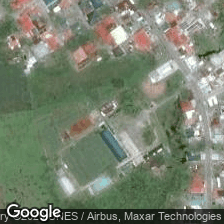

In [85]:
im = Image.open("./data/imagery/104408.0.png").convert("RGB")
im

In [86]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [90]:
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import torchvision

from imgaug import parameters as iap
from imgaug import augmenters as iaa
import imgaug as ia


In [91]:
to_tens = transforms.ToTensor()
im_tens = to_tens(im)
im_tens

tensor([[[0.4471, 0.5137, 0.5137,  ..., 0.4431, 0.4118, 0.4431],
         [0.4745, 0.5137, 0.4863,  ..., 0.4549, 0.4549, 0.4431],
         [0.5020, 0.4863, 0.4471,  ..., 0.4706, 0.3765, 0.4118],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1059, 0.1059, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.1059, 0.1059, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.1059, 0.1059, 0.1059]],

        [[0.4863, 0.5490, 0.5490,  ..., 0.4784, 0.4471, 0.4784],
         [0.5137, 0.5490, 0.5451,  ..., 0.4549, 0.4549, 0.4784],
         [0.5137, 0.5451, 0.4863,  ..., 0.4863, 0.4196, 0.4471],
         ...,
         [0.1373, 0.1373, 0.1373,  ..., 0.1333, 0.1333, 0.1333],
         [0.1373, 0.1373, 0.1373,  ..., 0.1333, 0.1333, 0.1333],
         [0.1373, 0.1373, 0.1373,  ..., 0.1333, 0.1333, 0.1333]],

        [[0.4157, 0.4745, 0.4745,  ..., 0.3843, 0.3529, 0.3843],
         [0.4392, 0.4745, 0.4549,  ..., 0.3608, 0.3608, 0.3843],
         [0.4549, 0.4549, 0.4157,  ..., 0.4078, 0.3255, 0.

In [79]:
trans = ImgAugTransform()

/home/hbaier/anaconda3/envs/geo/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


In [93]:
im_tens.shape

torch.Size([3, 224, 224])

In [97]:
torch.tensor(im_tens, dtype = torch.uint8).shape

/home/hbaier/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([3, 224, 224])

In [255]:
#### TRANSFORM DATA ####
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        # iaa.Scale((224, 224)),
        iaa.Sometimes(0.40, iaa.GaussianBlur(sigma=(0, 3.0))),
                iaa.Sometimes(0.25, iaa.Multiply((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(0.20, iaa.Invert(0.25, per_channel=0.5)),
                iaa.Sometimes(0.40, iaa.ReplaceElementwise(
                    iap.FromLowerResolution(iap.Binomial(0.1), size_px=8),
                    iap.Normal(128, 0.4*128),
                    per_channel=0.5)
                                         ),
                iaa.Sometimes(0.30, iaa.AdditivePoissonNoise(40)),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.30,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = self.aug.augment_image(img)
    to_tens = transforms.ToTensor()
    img = to_tens(img)
    return img


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(.001)
    # plt.clf()

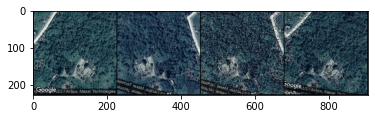

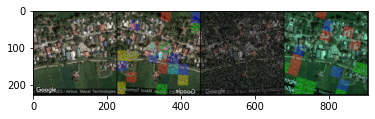

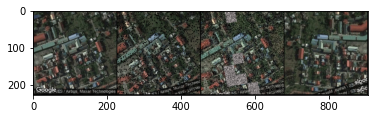

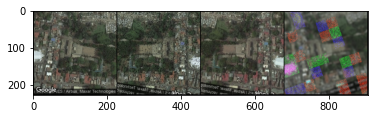

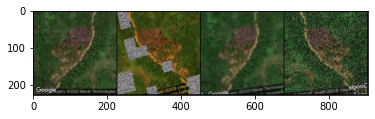

<Figure size 432x288 with 0 Axes>

In [259]:
BASE_DIR = "./data/imagery/"
trans = ImgAugTransform()

def plot_image_transforms(BASE_DIR, trans):
    for i in os.listdir(BASE_DIR)[0:5]:
        cur_transforms = []
        cur_im = Image.open(os.path.join(BASE_DIR, i)).convert("RGB")
        cur_transforms.append(to_tens(cur_im))
        for j in range(0, 3):
            cur_transforms.append(trans(np.array(cur_im)))
        to_plot = torchvision.utils.make_grid(cur_transforms)
        imshow(to_plot)
        plt.clf()

plot_image_transforms(BASE_DIR, trans)

In [268]:
from __future__ import print_function, division
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pandas as pd
import numpy as np
import torch
import os

In [280]:
class AugmentedSchoolDatasetBinary(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform_class, num_transforms = 3):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.schools_df = pd.read_csv(csv_file)
        self.trans = transform_class
        self.image_paths = []
        self.labels = []
        self.data = []

        for image in os.listdir(root_dir):
            cur_schoolid = image.split(".")[0]
            cur_df = self.schools_df[self.schools_df['school_id'] == int(cur_schoolid)]

            # Append the label
            self.labels.append(cur_df.intervention.values[0])

            # Append the image path
            self.image_paths.append(os.path.join(root_dir, image))

            # Append the tuple (image_tensor, class)
            cur_im = self.loadImage(os.path.join(root_dir, image))

            self.data.append((cur_im, cur_df.intervention.values[0]))

            for t in range(0, num_transforms):
                self.data.append((self.transform_image(os.path.join(root_dir, image)), cur_df.intervention.values[0]))


    # BASE_DIR = "./data/imagery/"
    # trans = ImgAugTransform()

    def transform_image(self, impath):
        cur_im = Image.open(impath).convert('RGB')
        return self.trans(np.array(cur_im))

    def loadImage(self, impath):
        to_tens = transforms.ToTensor()
        return to_tens(Image.open(impath).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        path = self.image_paths[index]
        return self.loadImage(path), self.labels[index]

In [279]:
dataset = AugmentedSchoolDatasetBinary("./data/y1314_AllSubjects.csv", "./data/imagery/", ImgAugTransform())
len(dataset.data)

20